# Datasets with missing values from 2013-2024

In [4]:
import pandas as pd
import numpy as np
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Use statsmodels ARIMA
from statsmodels.tsa.arima.model import ARIMA

def forecast_with_arima(df, value_col, target_range=(2013, 2024), min_historical_years=5):
    """
    Forecast missing years for each geo using ARIMA.
    Falls back to simple extrapolation if ARIMA fails.
    """
    results = []
    
    for geo in df['geo'].unique():
        geo_data = df[df['geo'] == geo].sort_values('time')
        
        existing_years = geo_data['time'].values
        existing_values = geo_data[value_col].values
        
        if len(existing_years) < min_historical_years:
            continue
        
        # Find missing years in target range
        target_years = list(range(target_range[0], target_range[1] + 1))
        missing_years = [y for y in target_years if y not in existing_years]
        
        if not missing_years:
            continue
        
        # Determine how many steps to forecast
        last_year = max(existing_years)
        years_to_forecast = [y for y in missing_years if y > last_year]
        
        if not years_to_forecast:
            continue
        
        steps = len(years_to_forecast)
        
        try:
            # Fit ARIMA model - (p, d, q) = (1, 1, 1) is a common starting point
            # Auto-select order using simple heuristic
            model = ARIMA(existing_values, order=(1, 1, 1))
            fitted = model.fit()
            
            # Forecast
            forecast = fitted.forecast(steps=steps)
            
            for i, year in enumerate(years_to_forecast):
                predicted_value = forecast[i]
                # Ensure non-negative for metrics that can't be negative
                if value_col != 'aid_received_per_person_current_us':
                    predicted_value = max(0, predicted_value)
                results.append({
                    'geo': geo,
                    'time': year,
                    value_col: predicted_value,
                    'is_forecasted': True
                })
        except Exception as e:
            # Fallback: use last known value with slight trend
            last_value = existing_values[-1]
            if len(existing_values) >= 2:
                trend = (existing_values[-1] - existing_values[-2]) / 2  # Dampened trend
            else:
                trend = 0
            
            for i, year in enumerate(years_to_forecast):
                predicted_value = last_value + trend * (i + 1)
                if value_col != 'aid_received_per_person_current_us':
                    predicted_value = max(0, predicted_value)
                results.append({
                    'geo': geo,
                    'time': year,
                    value_col: predicted_value,
                    'is_forecasted': True
                })
    
    return pd.DataFrame(results)

def process_dataset(filepath, value_col, target_range=(2013, 2024)):
    """Process a dataset and add ARIMA-forecasted values."""
    df = pd.read_csv(filepath)
    df['is_forecasted'] = False
    
    forecasted = forecast_with_arima(df, value_col, target_range)
    
    if len(forecasted) > 0:
        combined = pd.concat([df, forecasted], ignore_index=True)
        combined = combined.sort_values(['geo', 'time']).reset_index(drop=True)
        return combined
    return df

# Define datasets
datasets = {
    'life_expectancy_at_birth_data_from_ihme': {
        'path': 'data/gapminder/Physical/ddf--datapoints--life_expectancy_at_birth_data_from_ihme--by--geo--time.csv',
        'value_col': 'life_expectancy_at_birth_data_from_ihme'
    },
    'suicide_per_100000_people': {
        'path': 'data/gapminder/Physical/ddf--datapoints--suicide_per_100000_people--by--geo--time.csv',
        'value_col': 'suicide_per_100000_people'
    },
    'aid_received_per_person_current_us': {
        'path': 'data/gapminder/Economic/ddf--datapoints--aid_received_per_person_current_us--by--geo--time.csv',
        'value_col': 'aid_received_per_person_current_us'
    },
    'income_per_person_long_series': {
        'path': 'data/gapminder/Economic/ddf--datapoints--income_per_person_long_series--by--geo--time.csv',
        'value_col': 'income_per_person_long_series'
    },
    'cell_phones_per_100_people': {
        'path': 'data/gapminder/Social/ddf--datapoints--cell_phones_per_100_people--by--geo--time.csv',
        'value_col': 'cell_phones_per_100_people'
    },
    'mean_years_in_school_men_15_to_24_years': {
        'path': 'data/gapminder/Cultural/ddf--datapoints--mean_years_in_school_men_15_to_24_years--by--geo--time.csv',
        'value_col': 'mean_years_in_school_men_15_to_24_years'
    },
    'energy_use_per_person': {
        'path': 'data/gapminder/Environmental/ddf--datapoints--energy_use_per_person--by--geo--time.csv',
        'value_col': 'energy_use_per_person'
    }
}

# Process each dataset
processed_datasets = {}
for name, config in datasets.items():
    print(f"\n📊 Processing: {name}")
    filepath = Path(config['path'])
    
    if not filepath.exists():
        print(f"  ❌ File not found: {filepath}")
        continue
    
    original_df = pd.read_csv(filepath)
    original_years = original_df['time'].unique()
    print(f"  Original years: {min(original_years)} - {max(original_years)}")
    print(f"  Original rows: {len(original_df)}")
    
    processed_df = process_dataset(filepath, config['value_col'])
    processed_datasets[name] = processed_df
    
    forecasted_count = processed_df['is_forecasted'].sum()
    print(f"  🔮 ARIMA forecasted rows added: {forecasted_count}")
    print(f"  New total rows: {len(processed_df)}")
    
    final_years = processed_df['time'].unique()
    print(f"  Final years: {min(final_years)} - {max(final_years)}")

# Save processed datasets
output_dir = Path('data/gapminder/processed')
output_dir.mkdir(parents=True, exist_ok=True)

for name, df in processed_datasets.items():
    output_path = output_dir / f'{name}_with_forecasts.csv'
    df.to_csv(output_path, index=False)
    print(f"\n💾 Saved: {output_path}")

print("\n✅ All datasets processed with ARIMA forecasting!")


📊 Processing: life_expectancy_at_birth_data_from_ihme
  Original years: 1990 - 2013
  Original rows: 4512
  🔮 ARIMA forecasted rows added: 2068
  New total rows: 6580
  Final years: 1990 - 2024

📊 Processing: suicide_per_100000_people
  Original years: 2000 - 2021
  Original rows: 4070
  🔮 ARIMA forecasted rows added: 555
  New total rows: 4625
  Final years: 2000 - 2024

📊 Processing: aid_received_per_person_current_us
  Original years: 1960 - 2023
  Original rows: 8907
  🔮 ARIMA forecasted rows added: 519
  New total rows: 9426
  Final years: 1960 - 2024

📊 Processing: income_per_person_long_series
  Original years: 730 - 2019
  Original rows: 50215
  🔮 ARIMA forecasted rows added: 1122
  New total rows: 51337
  Final years: 730 - 2024

📊 Processing: cell_phones_per_100_people
  Original years: 1960 - 2023
  Original rows: 10350
  🔮 ARIMA forecasted rows added: 302
  New total rows: 10652
  Final years: 1960 - 2024

📊 Processing: mean_years_in_school_men_15_to_24_years
  Original ye

Found 7 processed datasets with forecasts


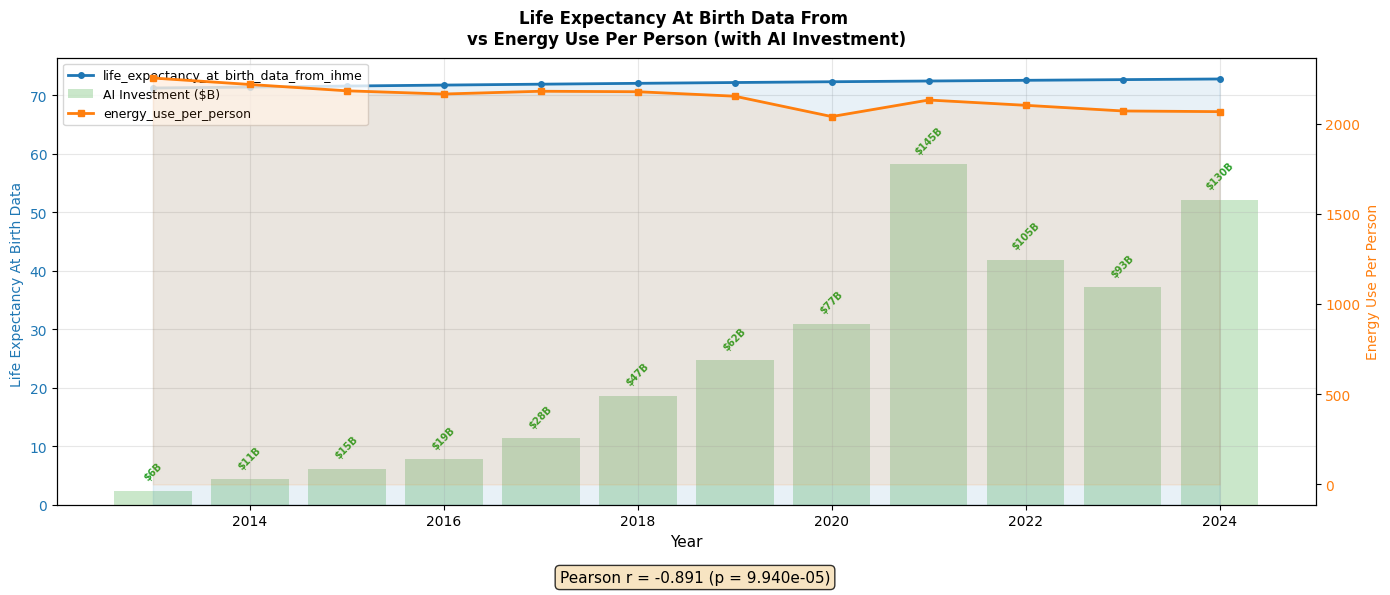

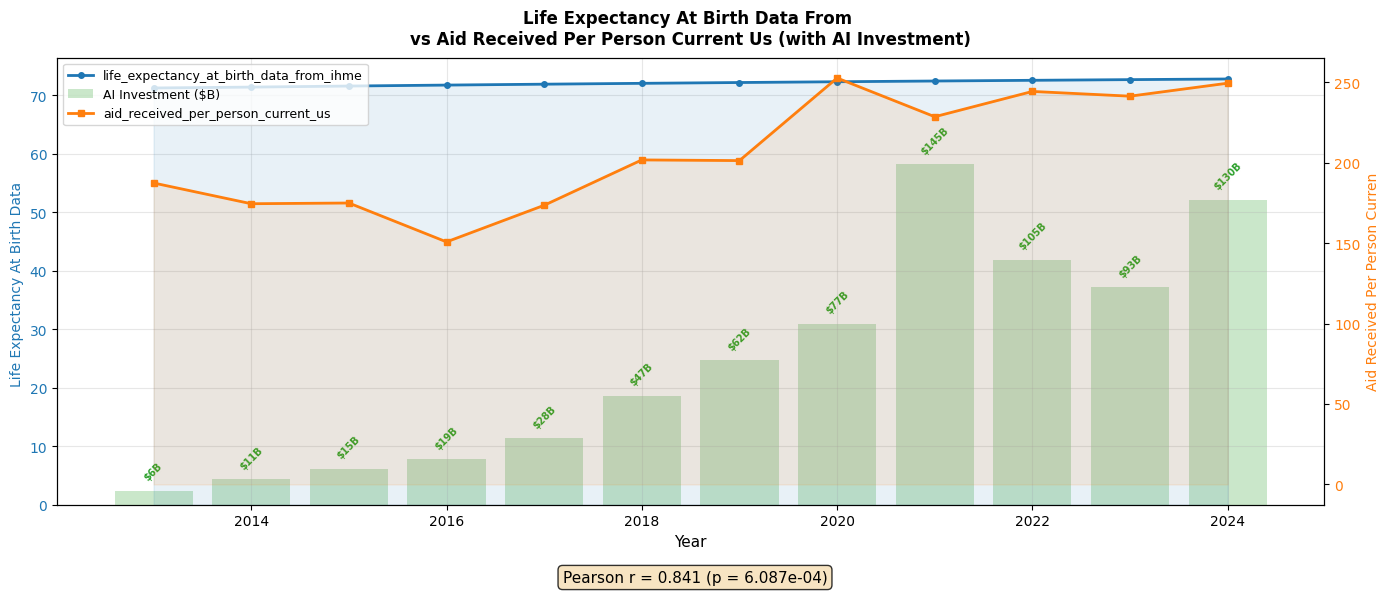

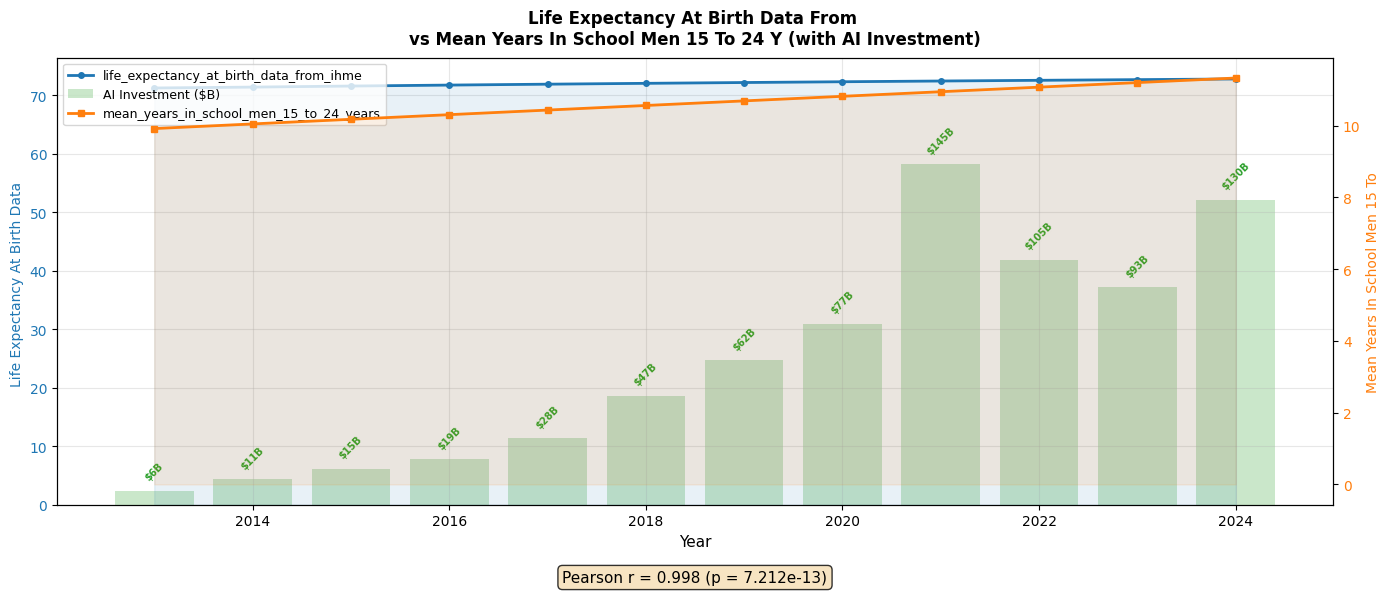

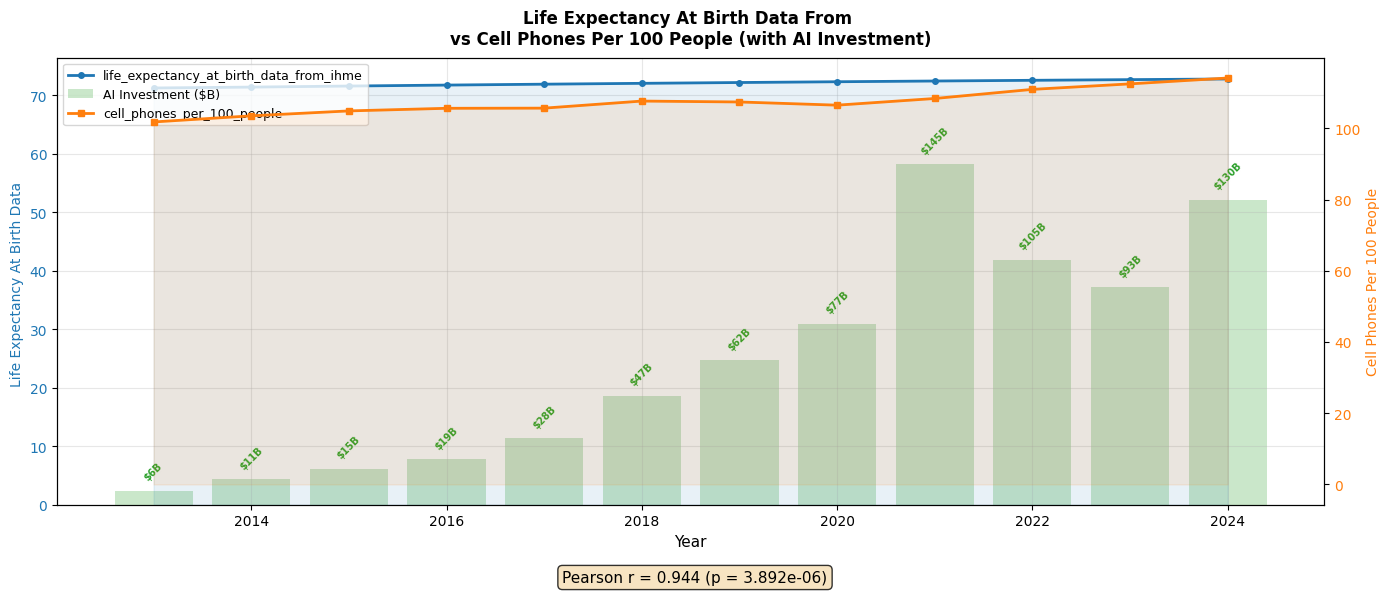

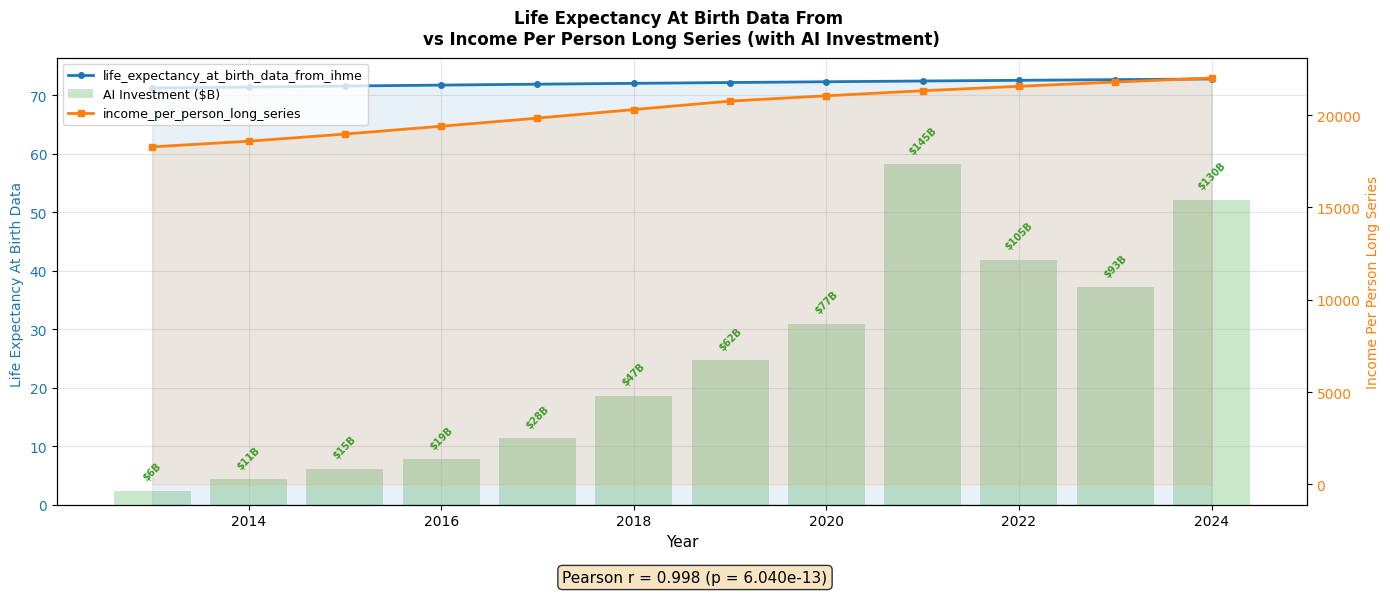

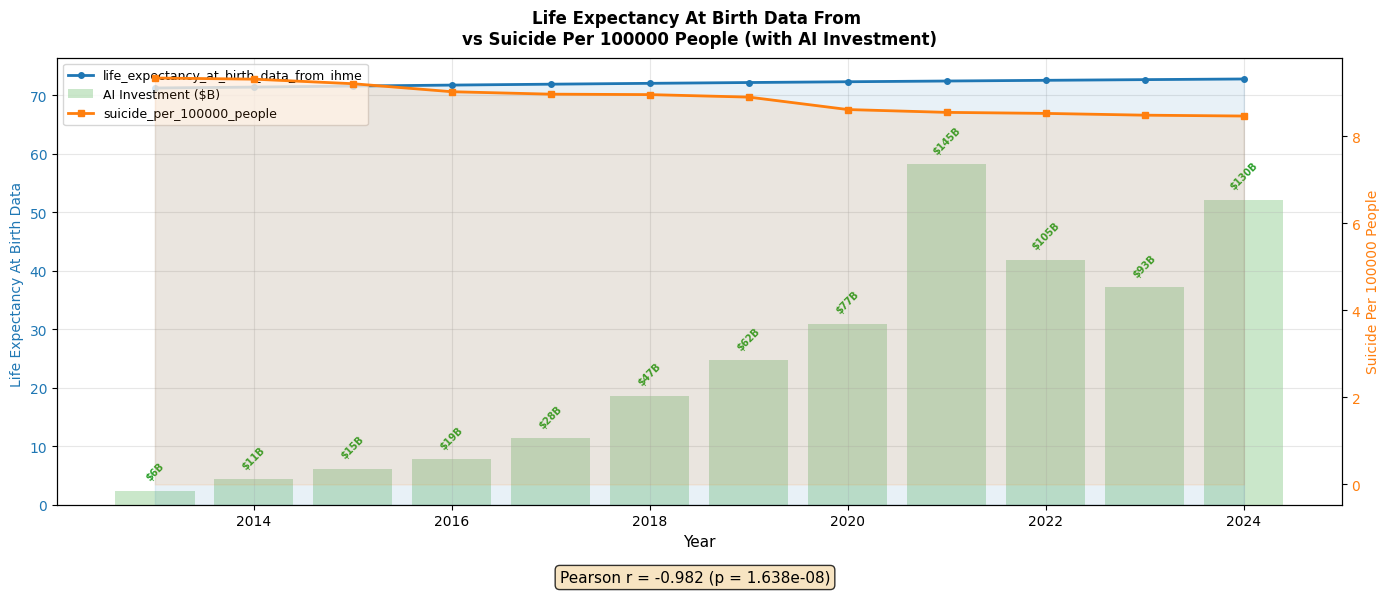

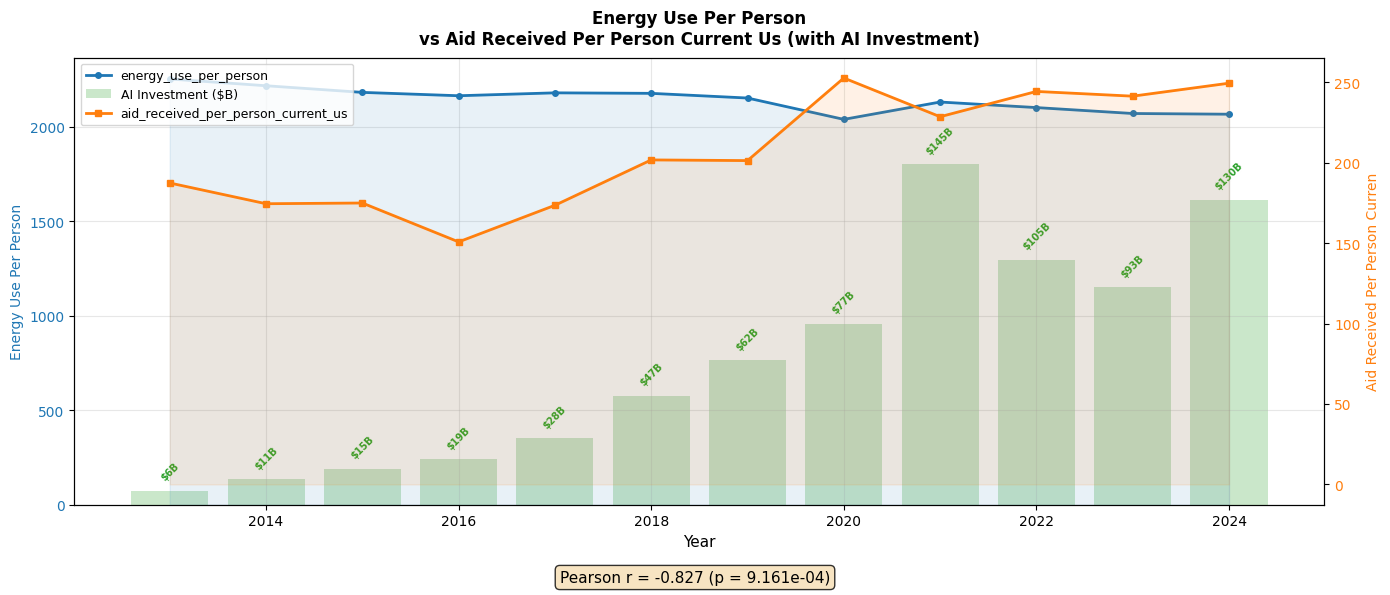

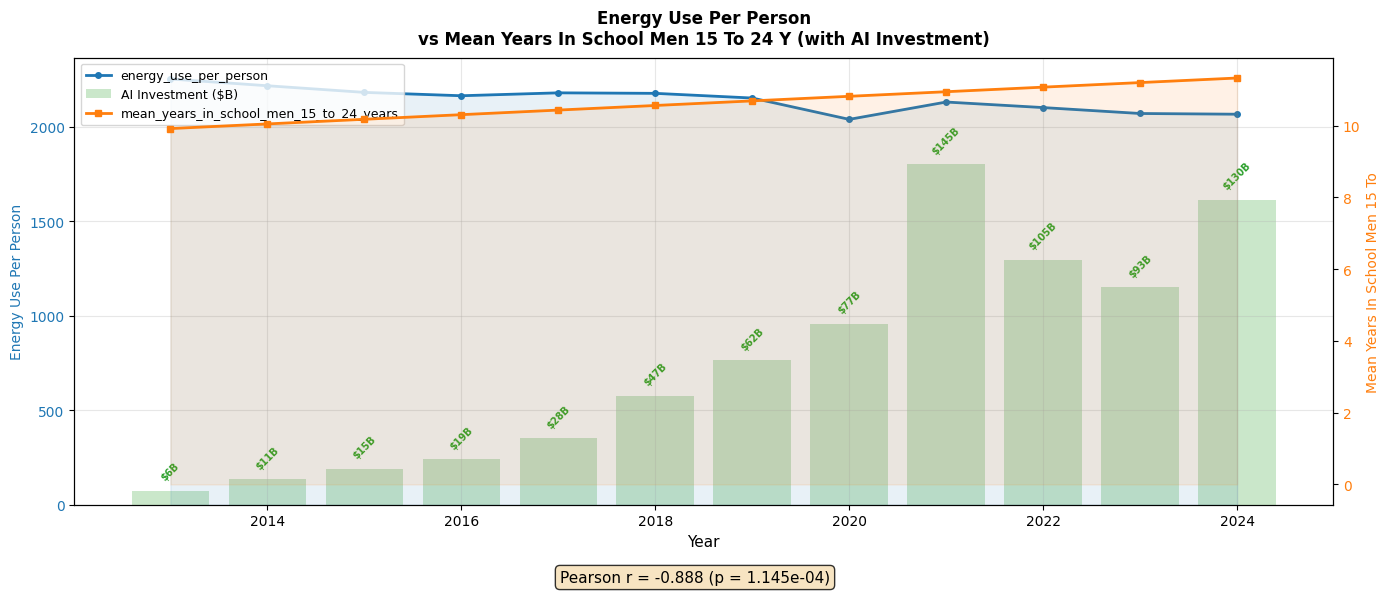

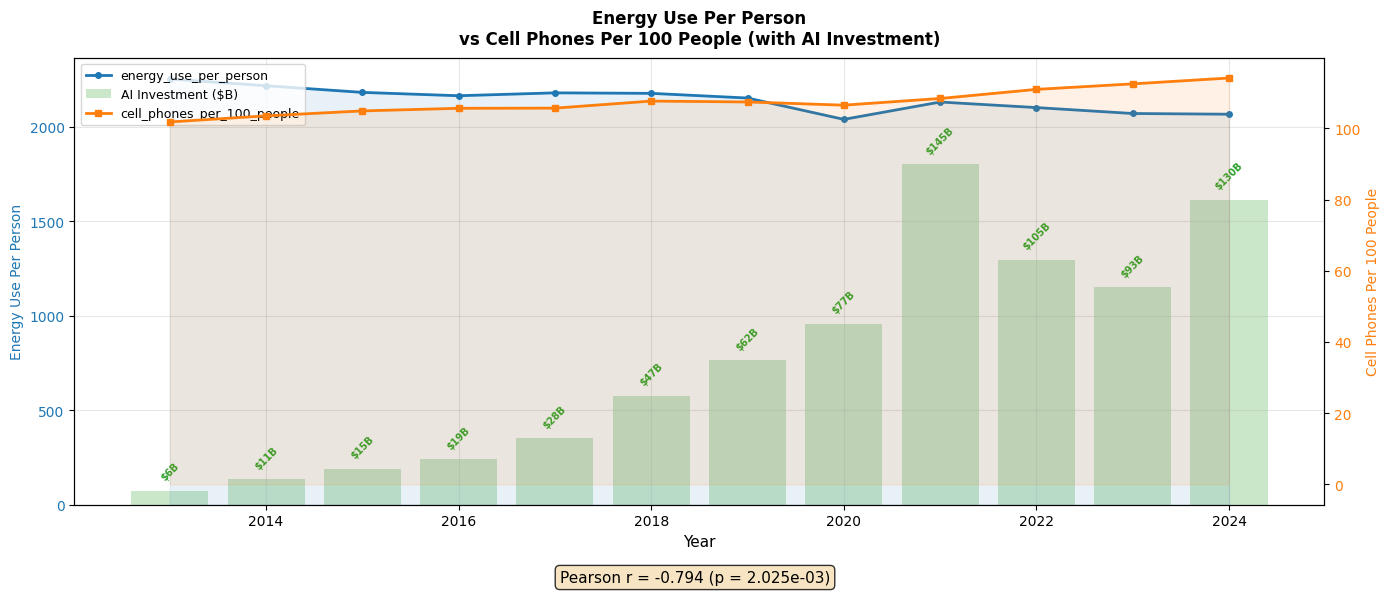

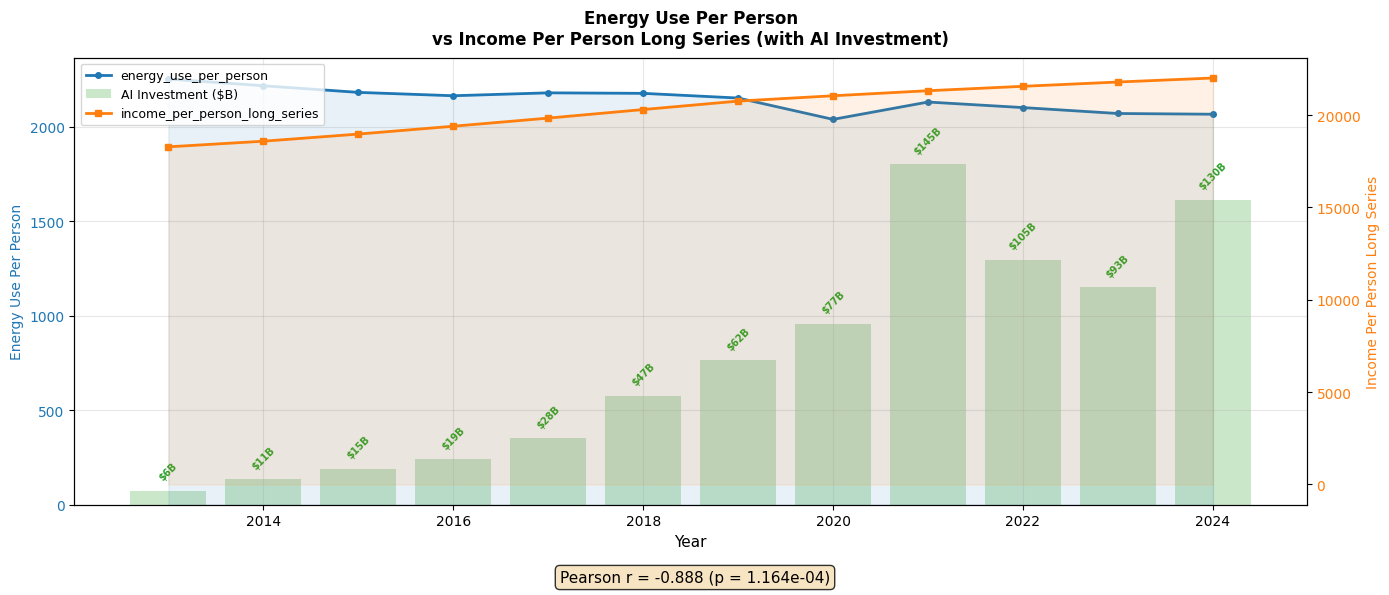

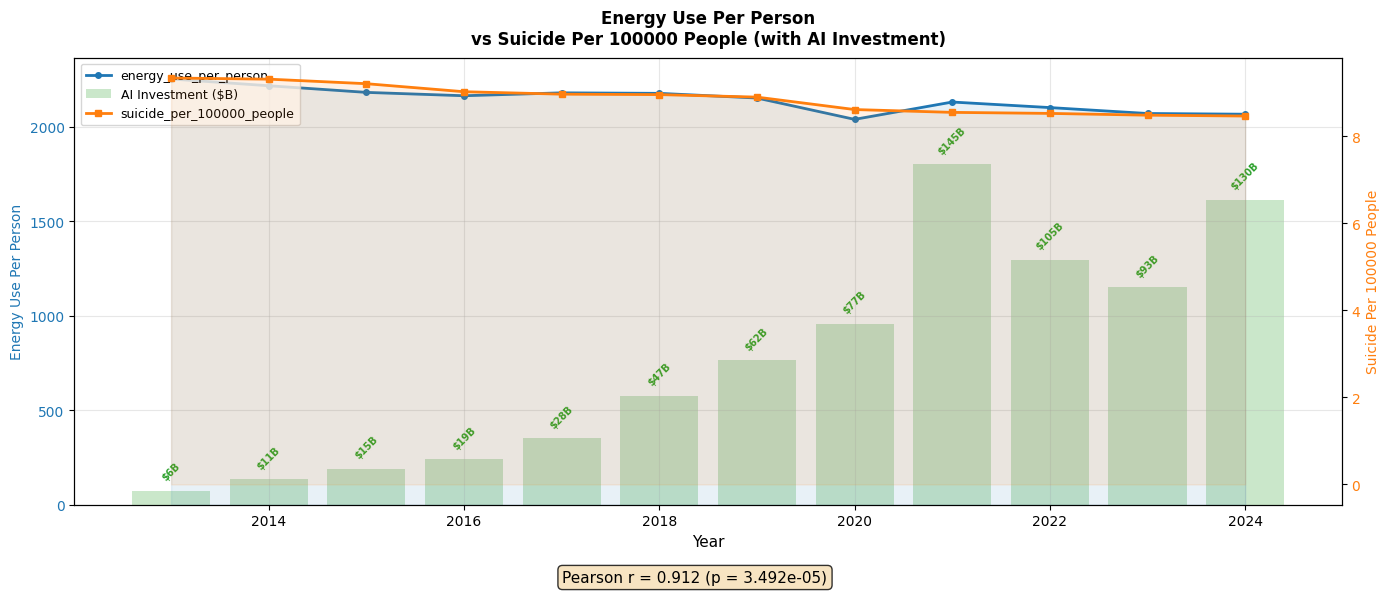

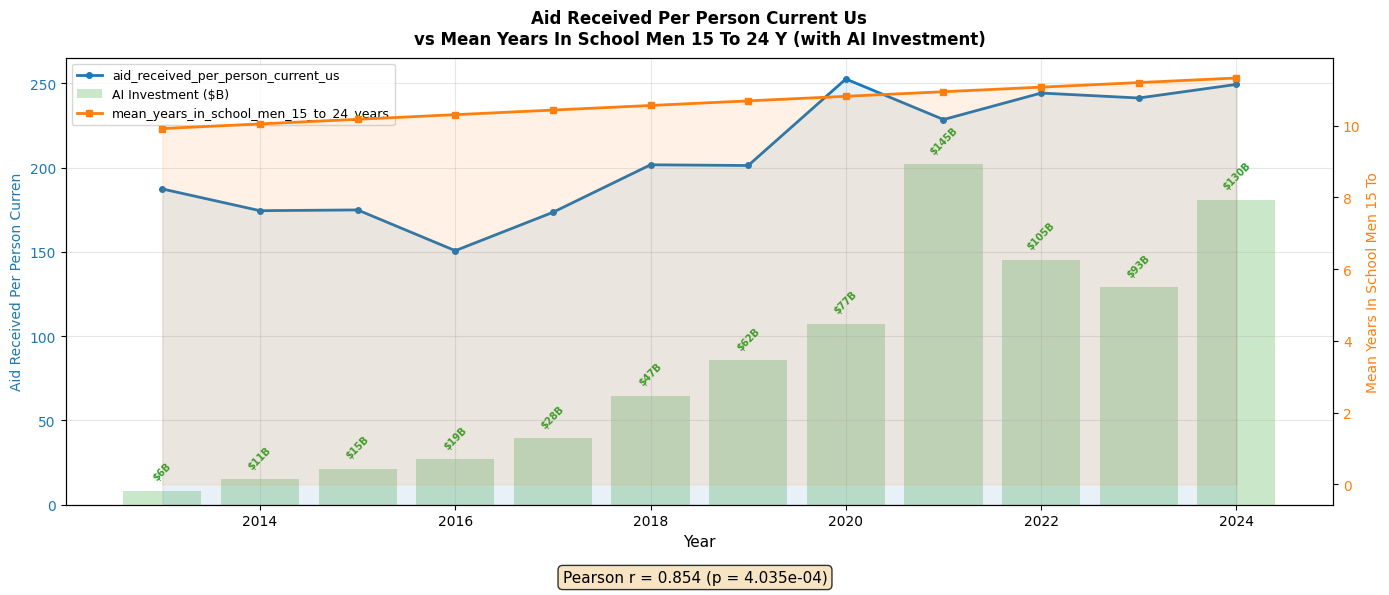

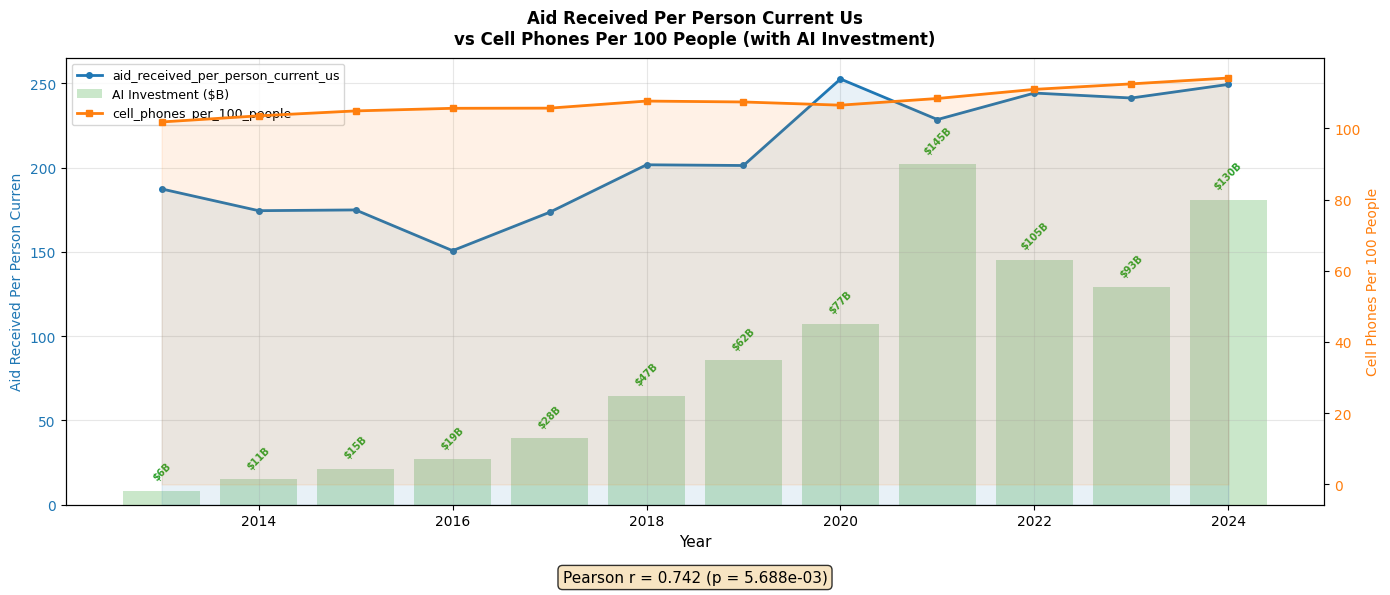

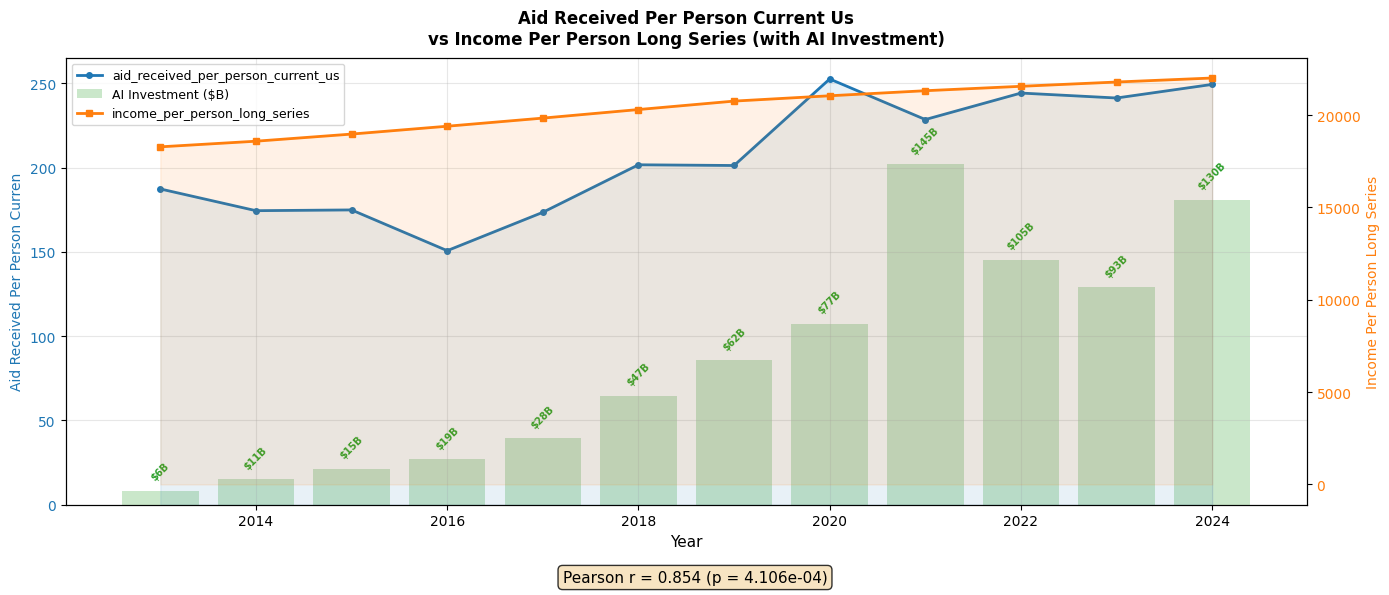

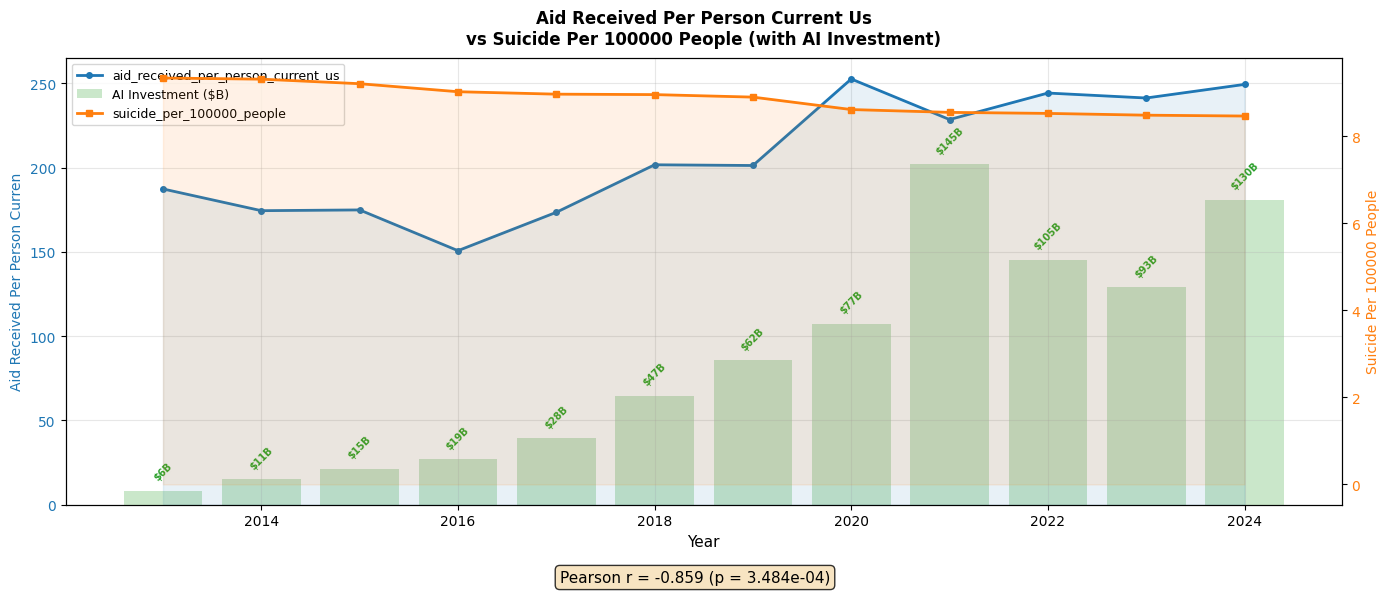

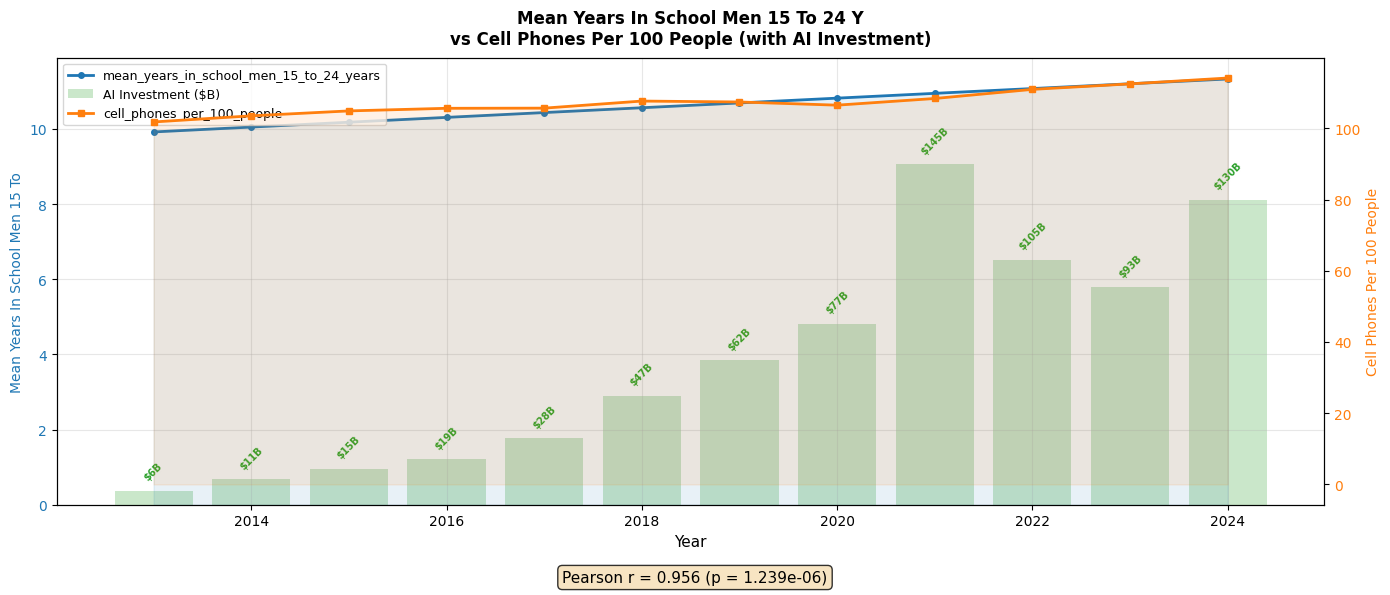

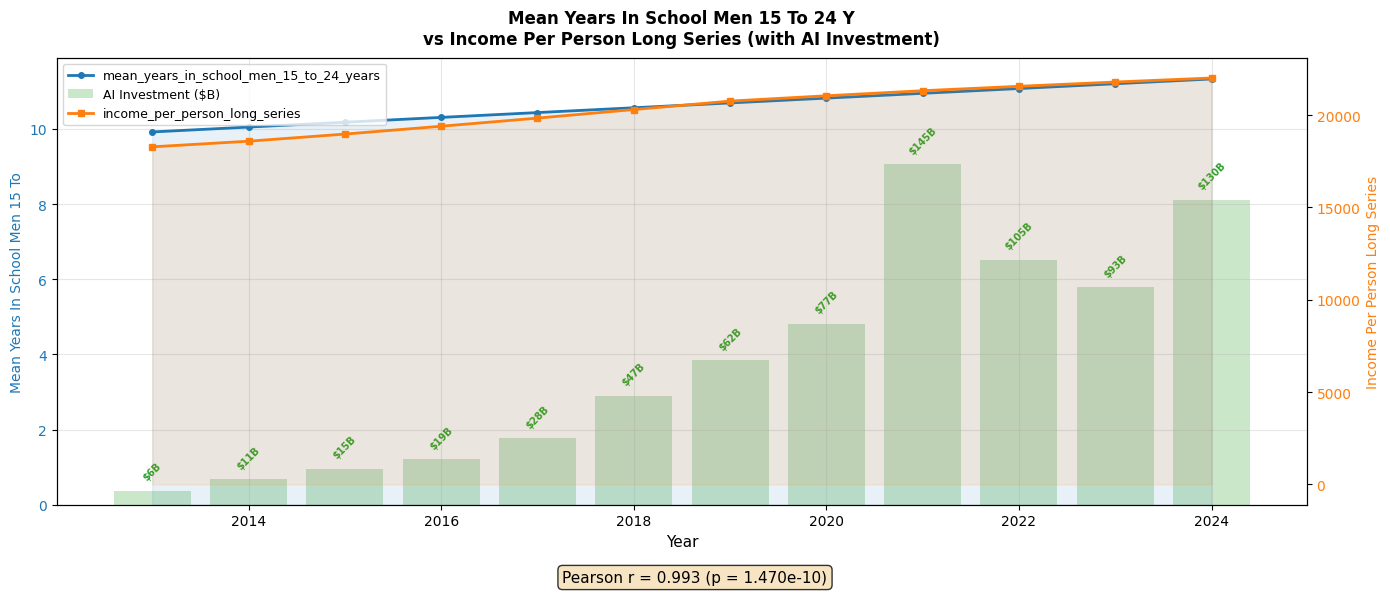

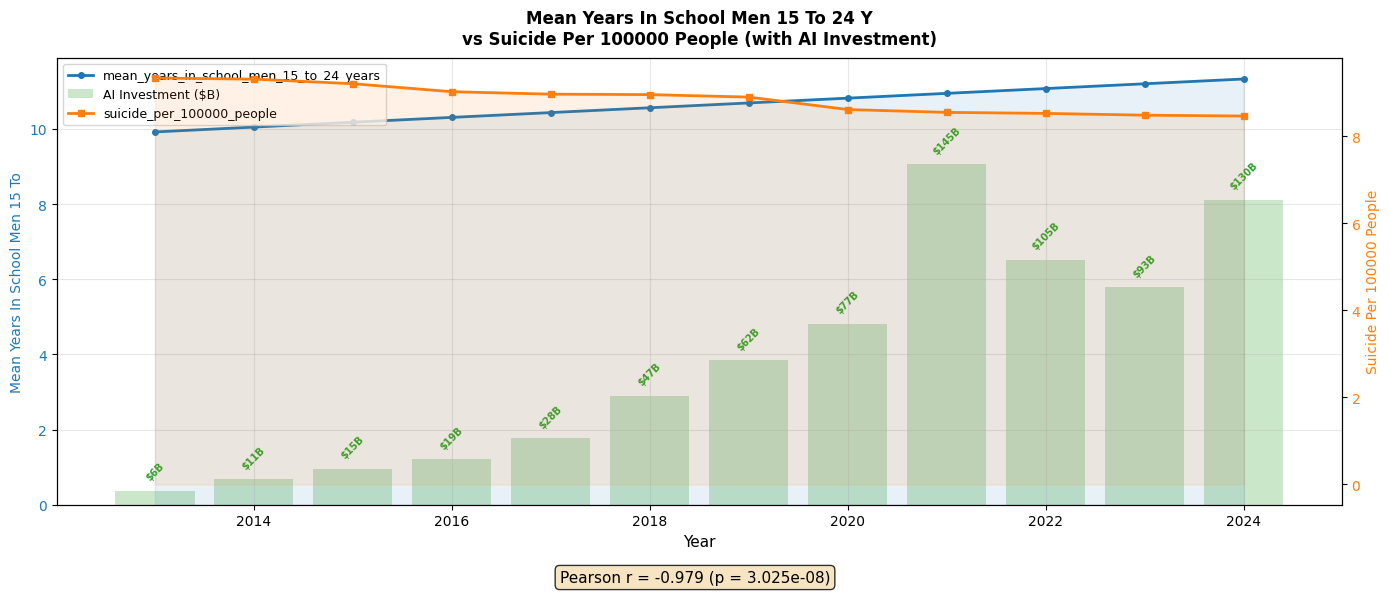

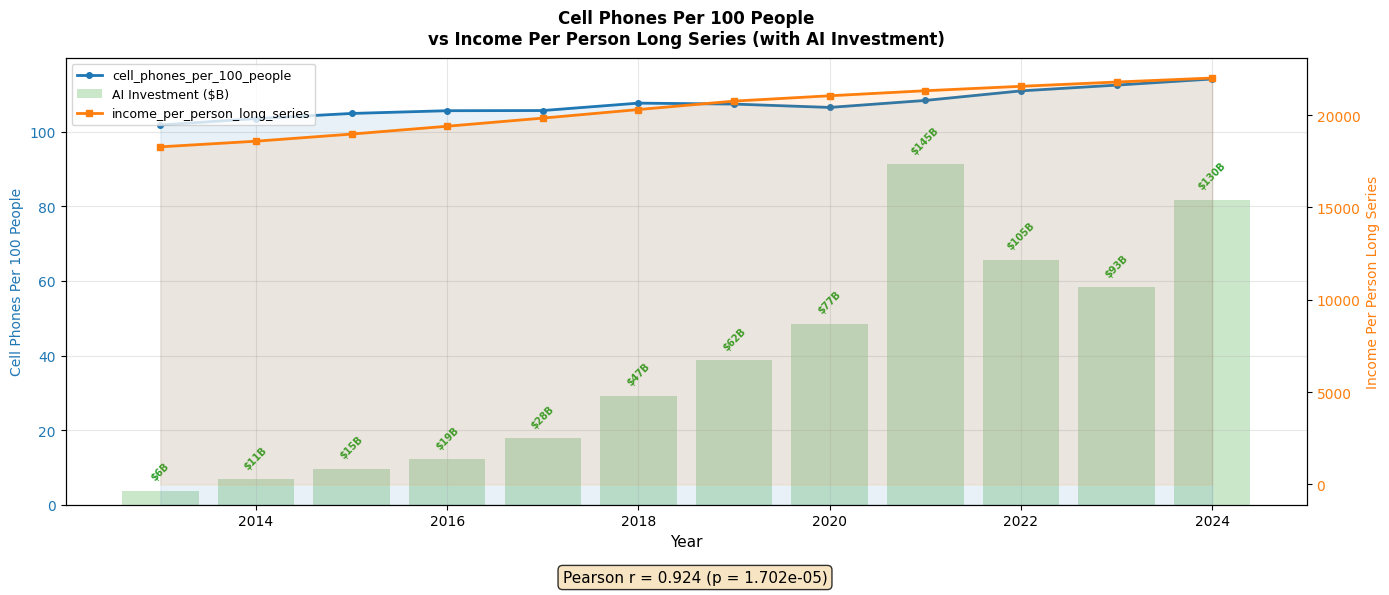

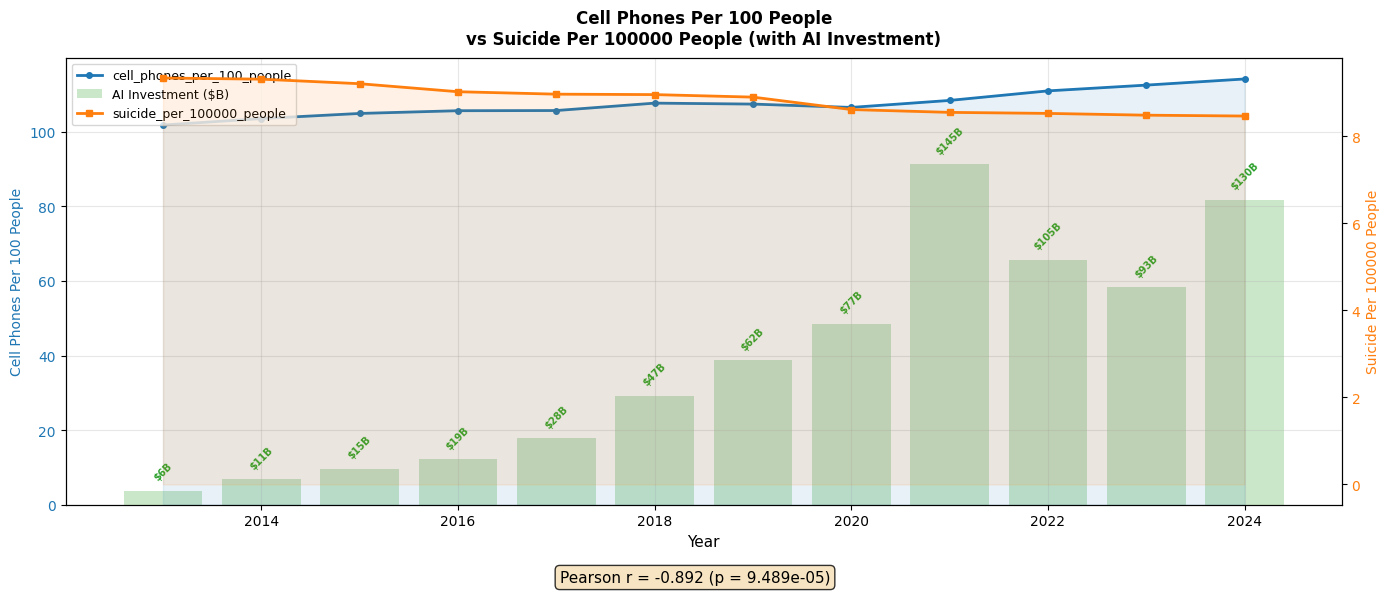

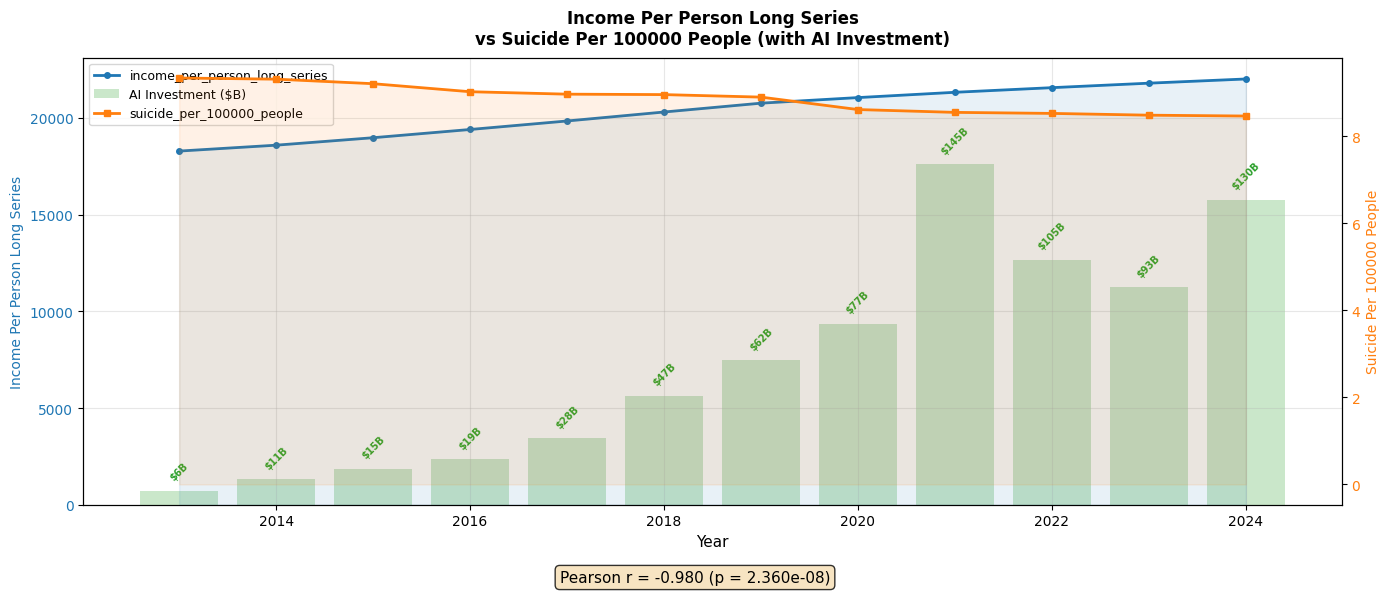

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from pathlib import Path
from itertools import combinations

# Load AI Investment data (World totals) and convert to billions
ai_investment_df = pd.read_csv('data/gapminder/AI_Technology/private-investment-in-artificial-intelligence.csv')
ai_investment_world = ai_investment_df[ai_investment_df['Entity'] == 'World'].copy()
ai_investment_world['investment_billions'] = ai_investment_world['Global total private investment in AI'] / 1e9
ai_investment_avg = ai_investment_world[['Year', 'investment_billions']].rename(columns={'Year': 'year'})

def load_processed_datasets():
    """Load the processed datasets with forecasts."""
    processed_dir = Path('./data/gapminder/processed')
    datasets = {}
    
    for file in processed_dir.glob('*_with_forecasts.csv'):
        # Extract indicator name from filename
        indicator = file.name.replace('_with_forecasts.csv', '')
        df = pd.read_csv(file)
        datasets[indicator] = df
    return datasets

def create_dual_axis_plot(df1, df2, name1, name2, year_range=(2013, 2024)):
    """Create a dual-axis line graph with AI Investment bars overlay."""
    col1 = [c for c in df1.columns if c not in ['geo', 'time', 'is_forecasted']][0]
    col2 = [c for c in df2.columns if c not in ['geo', 'time', 'is_forecasted']][0]
    
    df1_filtered = df1[(df1['time'] >= year_range[0]) & (df1['time'] <= year_range[1])]
    df2_filtered = df2[(df2['time'] >= year_range[0]) & (df2['time'] <= year_range[1])]
    
    agg1 = df1_filtered.groupby('time')[col1].mean().reset_index()
    agg2 = df2_filtered.groupby('time')[col2].mean().reset_index()
    
    if len(agg1) == 0 or len(agg2) == 0:
        return None
    
    ai_filtered = ai_investment_avg[(ai_investment_avg['year'] >= year_range[0]) & (ai_investment_avg['year'] <= year_range[1])]
    
    fig, ax1 = plt.subplots(figsize=(14, 6))
    
    # Scale AI investment bars to fit primary y-axis
    ai_max = ai_filtered['investment_billions'].max()
    y1_max = agg1[col1].max()
    ai_scaled = ai_filtered['investment_billions'] * (y1_max / ai_max) * 0.8
    
    # AI Investment bars with labels on top
    bars = ax1.bar(ai_filtered['year'], ai_scaled, alpha=0.25, color='#2ca02c', label='AI Investment ($B)', width=0.8, zorder=1)
    for bar, value in zip(bars, ai_filtered['investment_billions']):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + y1_max * 0.02, 
                 f'${value:.0f}B', ha='center', va='bottom', fontsize=7, color='#2ca02c', fontweight='bold', rotation=45)
    
    # First line (primary y-axis)
    ax1.set_xlabel('Year', fontsize=11)
    ax1.set_ylabel(name1.replace('_', ' ').title()[:30], color='#1f77b4', fontsize=10)
    ax1.plot(agg1['time'], agg1[col1], color='#1f77b4', linewidth=2, marker='o', markersize=4, label=name1, zorder=3)
    ax1.tick_params(axis='y', labelcolor='#1f77b4')
    ax1.fill_between(agg1['time'], agg1[col1], alpha=0.1, color='#1f77b4', zorder=2)
    
    # Second line (secondary y-axis)
    ax2 = ax1.twinx()
    ax2.set_ylabel(name2.replace('_', ' ').title()[:30], color='#ff7f0e', fontsize=10)
    ax2.plot(agg2['time'], agg2[col2], color='#ff7f0e', linewidth=2, marker='s', markersize=4, label=name2, zorder=3)
    ax2.tick_params(axis='y', labelcolor='#ff7f0e')
    ax2.fill_between(agg2['time'], agg2[col2], alpha=0.1, color='#ff7f0e', zorder=2)
    
    # Correlation
    merged = agg1.merge(agg2, on='time', how='inner')
    if len(merged) > 2:
        corr, p_val = pearsonr(merged[col1], merged[col2])
        fig.text(0.5, 0.02, f'Pearson r = {corr:.3f} (p = {p_val:.3e})', ha='center', fontsize=11, 
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    # Legend
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=9)
    
    plt.title(f'{name1.replace("_", " ").title()[:35]}\nvs {name2.replace("_", " ").title()[:35]} (with AI Investment)', fontsize=12, fontweight='bold', pad=10)
    fig.tight_layout(rect=[0, 0.05, 1, 1])
    ax1.grid(True, alpha=0.3)
    return fig

# Load processed datasets with forecasts
processed_datasets = load_processed_datasets()
print(f'Found {len(processed_datasets)} processed datasets with forecasts')

for name1, name2 in combinations(processed_datasets.keys(), 2):
    fig = create_dual_axis_plot(processed_datasets[name1], processed_datasets[name2], name1, name2)
    if fig:
        plt.show()
        plt.close()
